In [1]:
"""
# Random Forest Regression — NACA 4-Digit Airfoils

**Dataset:** AirfRANS (NACA 4-digit series only — 489 samples)
**Features:** Reynolds number, angle of attack, camber, camber position, thickness
**Target:** Lift-to-Drag ratio (L/D)

Random Forest averages multiple decision trees trained on bootstrapped samples.
Key hyperparameters:
- **n_estimators:** Number of trees in the forest
- **max_depth:** Maximum depth of each tree
- **max_features:** Features considered at each split (default: sqrt)
"""
from __future__ import annotations


from pathlib import Path
import sys


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


# ─────────────────────────────────────────────────────────────────────────────
# Setup paths
# ─────────────────────────────────────────────────────────────────────────────
def _find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').is_dir():
            return p
    raise RuntimeError(f"Could not find repo root from: {start}")


REPO_ROOT = _find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))


from src.config import DATA_DIR, RAW_DATASET_DIR
from src.tabular_data import load_airfrans_tabular_split


# ─────────────────────────────────────────────────────────────────────────────
# Load NACA 4-digit dataset
# ─────────────────────────────────────────────────────────────────────────────
csv_path = DATA_DIR / 'airfrans_dataset.csv'
manifest_path = RAW_DATASET_DIR / 'manifest.json'
task = 'full'


train_df, test_df = load_airfrans_tabular_split(csv_path, manifest_path, task=task)

# Clean NACA 4-digit features
feature_cols = ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']
target_col = 'L_D'

FEATURE_LABELS = {
    'Reynolds': 'Reynolds Number',
    'angle_of_attack_rad': 'Angle of Attack (rad)',
    'camber': 'Max Camber (%)',
    'camber_pos': 'Camber Position (tenths)',
    'thickness': 'Thickness (%)',
}


X_train = train_df[feature_cols]
y_train = np.asarray(train_df[target_col]).reshape(-1)
X_test = test_df[feature_cols]
y_test = np.asarray(test_df[target_col]).reshape(-1)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Features: {feature_cols}")


# ─────────────────────────────────────────────────────────────────────────────
# Preprocessing and evaluation function
# ─────────────────────────────────────────────────────────────────────────────
pre = Pipeline([('scaler', StandardScaler())])


def fit_eval(n_estimators: int, max_depth: int | None, min_samples_leaf: int = 5) -> dict:
    """Train Random Forest with given hyperparameters."""
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features='sqrt',
        min_samples_leaf=min_samples_leaf,
        bootstrap=True,
        random_state=42,
        n_jobs=-1,
    )
    pipe = Pipeline([('pre', pre), ('model', model)])
    pipe.fit(X_train, y_train)
    
    y_train_pred = np.asarray(pipe.predict(X_train)).reshape(-1)
    y_test_pred = np.asarray(pipe.predict(X_test)).reshape(-1)
    
    n_train, p = X_train.shape
    n_test = len(y_test)
    
    r2_tr = float(r2_score(y_train, y_train_pred))
    r2_te = float(r2_score(y_test, y_test_pred))
    
    # Adjusted R²
    r2_adj_tr = 1 - (1 - r2_tr) * (n_train - 1) / (n_train - p - 1)
    r2_adj_te = 1 - (1 - r2_te) * (n_test - 1) / (n_test - p - 1)
    
    rmse_te = float(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    
    # Feature importances
    importances = pipe.named_steps['model'].feature_importances_
    
    return {
        'n_estimators': n_estimators,
        'max_depth': -1 if max_depth is None else max_depth,
        'r2_train': r2_tr,
        'r2_test': r2_te,
        'r2_adj_train': r2_adj_tr,
        'r2_adj_test': r2_adj_te,
        'rmse_test': rmse_te,
        'gap': r2_tr - r2_te,
        'importances': importances,
    }

Training samples: 378, Test samples: 111
Features: ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']


In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# 2D Grid Search: n_estimators × max_depth
# ─────────────────────────────────────────────────────────────────────────────
n_estimators_grid = [25, 50, 100, 200, 300]
max_depth_grid = [3, 5, 7, 10, 15, None]

rows = [fit_eval(n, d) for n in n_estimators_grid for d in max_depth_grid]
res = pd.DataFrame(rows)
res['max_depth_label'] = res['max_depth'].replace({-1: 'None'}).astype(str)

# Best result
best = res.loc[res['r2_adj_test'].idxmax()]
print(f"\nBest configuration:")
print(f"  n_estimators = {int(best['n_estimators'])}, max_depth = {best['max_depth_label']}")
print(f"  Train R² adj = {best['r2_adj_train']:.4f}")
print(f"  Test R² adj  = {best['r2_adj_test']:.4f}")
print(f"  RMSE (test)  = {best['rmse_test']:.2f}")
print(f"  Overfit gap  = {best['gap']:.4f}")

res[['n_estimators', 'max_depth_label', 'r2_adj_train', 'r2_adj_test', 'rmse_test', 'gap']].sort_values('r2_adj_test', ascending=False).head(10)


Best configuration:
  n_estimators = 25, max_depth = 15
  Train R² adj = 0.9444
  Test R² adj  = 0.8805
  RMSE (test)  = 11.42
  Overfit gap  = 0.0592


,n_estimators,max_depth_label,r2_adj_train,r2_adj_test,rmse_test,gap
4,25,15,0.944396,0.880473,11.418565,0.059227
5,25,None,0.944396,0.880473,11.418565,0.059227
16,100,15,0.947695,0.878118,11.530489,0.064730
17,100,None,0.947695,0.878118,11.530489,0.064730
28,300,15,0.947891,0.877095,11.578784,0.065901
29,300,None,0.947891,0.877095,11.578784,0.065901
27,300,10,0.947764,0.876338,11.614419,0.066499
15,100,10,0.947372,0.876147,11.623379,0.066294
23,200,None,0.947147,0.875504,11.653499,0.066685
22,200,15,0.947147,0.875504,11.653499,0.066685


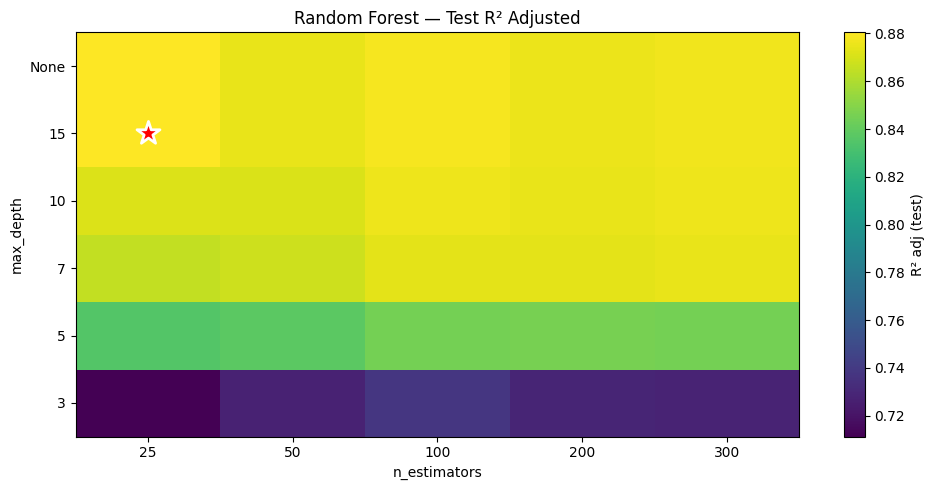


★ Best: n_estimators=25, max_depth=15 → R² = 0.8805


In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 1: Heatmap of Test R² (n_estimators × max_depth)
# ─────────────────────────────────────────────────────────────────────────────
pivot = res.pivot(index='max_depth_label', columns='n_estimators', values='r2_adj_test')
# Sort rows properly
row_order = ['3', '5', '7', '10', '15', 'None']
pivot = pivot.reindex([r for r in row_order if r in pivot.index])

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(pivot.values, aspect='auto', cmap='viridis', origin='lower')

ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)

ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_title('Random Forest — Test R² Adjusted')

# Mark best point
best_row_idx = list(pivot.index).index(best['max_depth_label'])
best_col_idx = list(pivot.columns).index(best['n_estimators'])
ax.scatter([best_col_idx], [best_row_idx], marker='*', s=300, c='red', edgecolors='white', linewidths=2)

plt.colorbar(im, label='R² adj (test)')
plt.tight_layout()
plt.show()

print(f"\n★ Best: n_estimators={int(best['n_estimators'])}, max_depth={best['max_depth_label']} → R² = {best['r2_adj_test']:.4f}")

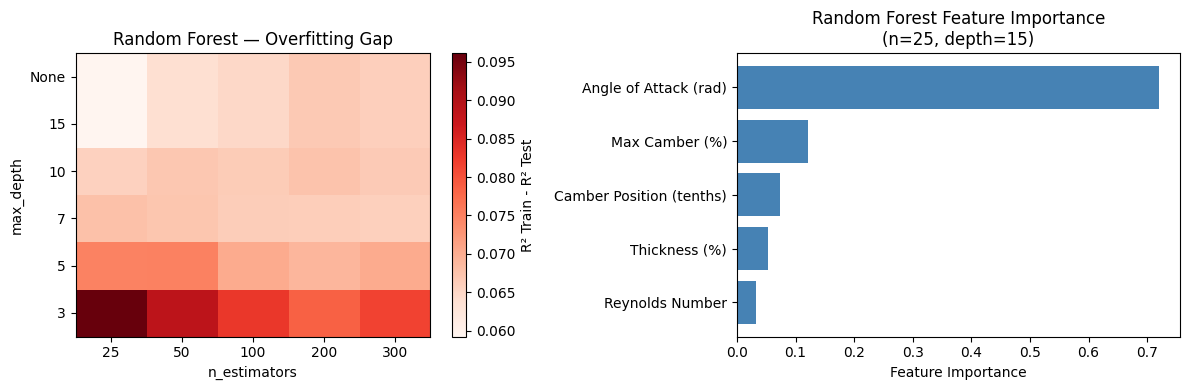

In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 2: Overfitting Gap + Feature Importances
# ─────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Overfitting gap heatmap
pivot_gap = res.pivot(index='max_depth_label', columns='n_estimators', values='gap')
pivot_gap = pivot_gap.reindex([r for r in row_order if r in pivot_gap.index])

im = axes[0].imshow(pivot_gap.values, aspect='auto', cmap='Reds', origin='lower')
axes[0].set_yticks(range(len(pivot_gap.index)))
axes[0].set_yticklabels(pivot_gap.index)
axes[0].set_xticks(range(len(pivot_gap.columns)))
axes[0].set_xticklabels(pivot_gap.columns)
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('max_depth')
axes[0].set_title('Random Forest — Overfitting Gap')
plt.colorbar(im, ax=axes[0], label='R² Train - R² Test')

# Right: Feature importances from best model
best_importances = best['importances']
sorted_idx = np.argsort(best_importances)[::-1]
labels = [FEATURE_LABELS.get(feature_cols[i], feature_cols[i]) for i in sorted_idx]

axes[1].barh(range(len(feature_cols)), best_importances[sorted_idx], color='steelblue')
axes[1].set_yticks(range(len(feature_cols)))
axes[1].set_yticklabels(labels)
axes[1].set_xlabel('Feature Importance')
axes[1].set_title(f'Random Forest Feature Importance\n(n={int(best["n_estimators"])}, depth={best["max_depth_label"]})')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

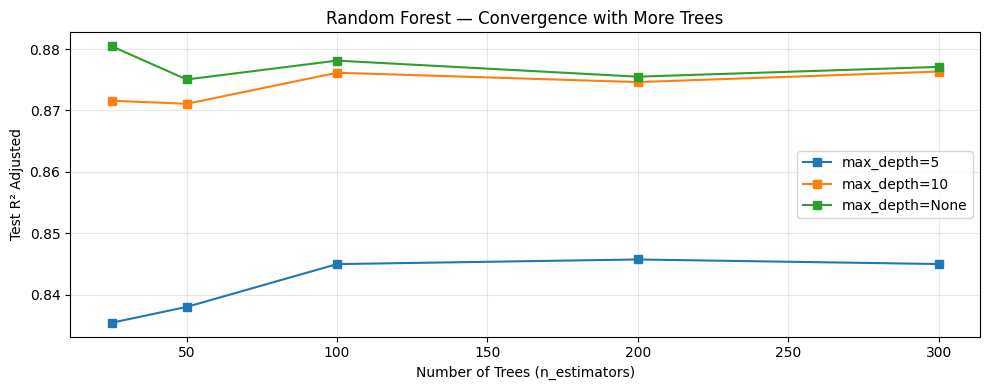


Observation: Performance plateaus after ~100 trees. More trees = slower training, marginal gains.


In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 3: R² vs n_estimators at different max_depth levels
# ─────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))

for depth_label in ['5', '10', 'None']:
    subset = res[res['max_depth_label'] == depth_label]
    ax.plot(subset['n_estimators'], subset['r2_adj_test'], 's-', label=f'max_depth={depth_label}', markersize=6)

ax.set_xlabel('Number of Trees (n_estimators)')
ax.set_ylabel('Test R² Adjusted')
ax.set_title('Random Forest — Convergence with More Trees')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation: Performance plateaus after ~100 trees. More trees = slower training, marginal gains.")

---

## Conclusions (Random Forest Only)

### Final Random Forest Metrics (Best Observed)
- **Best hyperparameters (sweep):** `n_estimators=25`, `max_depth=15`
- **Adjusted $R^2$ (train):** $0.944396$
- **Adjusted $R^2$ (test):** $0.880473$
- **Test RMSE:** $11.418565$
- **Overfit gap (train − test):** $0.059227$

### Key Deductions
1. **Random Forest underperforms boosted methods and MLP on this dataset.** The test $R^2_{adj}$ is substantially lower, indicating the forest is not capturing the mapping as efficiently as sequential boosting or a neural net.
2. **Depth helps until it doesn’t.** Larger `max_depth` improves fit, but the generalization gap remains noticeable; deeper trees mainly increase variance rather than improving test performance.
3. **More trees give diminishing returns.** Increasing `n_estimators` beyond a small ensemble does not materially improve test $R^2_{adj}$ in your sweep, suggesting the limiting factor is bias/structure rather than sampling noise.
4. **The gap indicates variance-driven error.** The consistent train–test gap implies the model is fitting idiosyncrasies of the training set that do not transfer perfectly to test.